In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

sc.getConf().getAll()

[('spark.executor.memory', '866m'),
 ('spark.driver.memory', '14400m'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.driver.host', 'c460-094.stampede2.tacc.utexas.edu'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'spark://c460-094:7077'),
 ('spark.submit.pyFiles', ''),
 ('spark.io.compression.codec', 'org.apache.spark.io.LZ4CompressionCodec'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'app-20200926122139-0000'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '38741')]

In [2]:
# https://1oclockbuzz.wordpress.com/2015/11/24/pyspark-and-the-mandelbrot-set-overkill-indeed/

def check_c(c, rel_tol=1e-6, max_zmag=1e6):
    """Checks whether or not c is in the Mandelbrot Set"""
    z = np.zeros(500, dtype=complex)
    zmag = np.zeros(500)    
    for i in range(1, 500):
        z[i] = z[i-1]**2 + c
        zmag[i] = np.abs(z[i])    
        if np.isnan(z[i]) or zmag[i] > max_zmag:
            return (None, None)
         
        rel_diff = np.abs((zmag[i] - zmag[i-1])/zmag[i])
        if rel_diff < rel_tol:
            return (c, zmag[i])
     
    return(c, zmag[i])

def candidates_rdd(n):
    """Generates candidate complex numbers for Mandelbrot Set"""
    c = np.linspace(-1, 1, n)
    def c_helper(r_part):
        return r_part+c*1j
    r = sc.parallelize(np.linspace(-2,2,n))
    return r.flatMap(c_helper)

In [3]:
c_rdd = candidates_rdd(1000)
num_part = c_rdd.getNumPartitions()
print("Candidate RDD is currently split into %i partitions"%(num_part))

Candidate RDD is currently split into 66 partitions


In [4]:
time_start = time.time()
mandelbrot_set = c_rdd.repartition(num_part*2).map(check_c)\
                  .filter(lambda x: True if x[0] else False)\
                  .repartition(num_part*2)\
                  .map(lambda x: (np.real(x[0]), np.imag(x[0]), x[1]))\
                  .collect()
total_time = time.time() - time_start
print("Computing the mandelbrot set took %i seconds"%(int(total_time)))

Computing the mandelbrot set took 112 seconds


In [5]:
x = np.ravel([c[0] for c in mandelbrot_set])
y = np.ravel([c[1] for c in mandelbrot_set])
z = np.ravel([c[2] for c in mandelbrot_set])

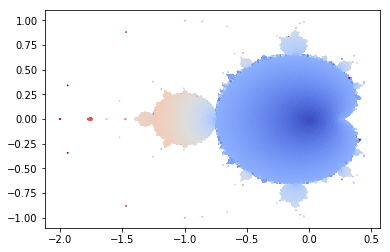

In [6]:
plt.scatter(x, y, c=z, vmin=0, vmax=2.0, cmap='coolwarm', s=1, marker='*', facecolor='none')
plt.show()